In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap, bar_chart

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.train.pickle', 'rb') as file:
    network = pickle.load(file)
    network.G.remove_edges_from(network.G.selfloop_edges(data=True))

In [3]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
    network_val.G.remove_edges_from(network_val.G.selfloop_edges(data=True))

In [4]:
# with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
#     luad_data = pickle.load(file)
#     network.multi_omics_data = luad_data
#     network.process_genes_info()

In [5]:
import pickle
with open('moge/data/luad_data_multi_U-T.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network.process_genes_info()
    network_val.multi_omics_data = luad_data
    network_val.process_genes_info()

Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']
Number of nodes without seq removed: -9088
Total nodes (filtered): 23653
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']
Number of nodes without seq removed: -10093
Total nodes (filtered): 22648


In [6]:
network.genes_info["Transcript length"] = network.genes_info["Transcript sequence"].apply(lambda x: len(x) if type(x) == str else None)
network.genes_info["Transcript length"].describe(percentiles=[.50, .75, .85, .90, .95, .99])

count     0
unique    0
Name: Transcript length, dtype: int64

In [7]:
# import yaml
# with open("logs/SiameseGraphEmbeddin_03-29_11-50PM/params.txt", "r") as file:
#     params = yaml.load(str(file.read()))
#     params["subsample"] = False
#     siamese.set_params(**params)
#     file.close()
    
# siamese.load_model("logs/SiameseGraphEmbeddin_03-29_11-50PM/lstm_model.e5.h5", network)

# Data Visualization

In [8]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

In [9]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

In [10]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

In [11]:
# The test data to recall
# matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [6]:
params = {
    'd': 128, 
    'lr': 0.001, 
    'margin': 0.5,
    'weighted': True,
    # 'subsample': True,
    'directed_proba': 1.0,
    'compression_func': 'sqrt',
    'negative_sampling_ratio': 10.0,
    'max_length': 5050, 
    'truncating': 'random', 
    
    'conv1_kernel_size': 18, 
    'conv1_batch_norm': True,
    'max1_pool_size': 9, 
    'conv2_kernel_size': 6,
    'conv2_batch_norm': True,
    'max2_pool_size': 4, 
    'lstm_unit_size': 320, 
    'dense1_unit_size': 1024, 
    'dense2_unit_size': None, 
    'directed_distance': "euclidean",
    'undirected_distance': "euclidean",
    'source_target_dense_layers': False,
    'embedding_normalization': False
}

In [7]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
from moge.embedding.siamese_triplet_online_embedding import SiameseOnlineTripletGraphEmbedding

siamese = SiameseOnlineTripletGraphEmbedding(batch_size=225, epochs=30, verbose=True)
# siamese = SiameseGraphEmbedding(batch_size=400, epochs=10, verbose=True)

# siamese = SiameseTripletGraphEmbedding(d=128, batch_size=256, margin=0.2, lr=0.001, epochs=30, 
#     negative_sampling_ratio=2.0, directed_proba=0.8, compression_func="sqrt3",
#     max_length=2000, truncating="post", verbose=True)

siamese.set_params(**params)

directed_margin 0.2 , undirected_margin 0.1


Using TensorFlow backend.


SiameseOnlineTripletGraphEmbedding(batch_size=225, compression_func='sqrt',
                  conv1_batch_norm=True, conv1_kernel_size=18,
                  conv2_batch_norm=True, conv2_kernel_size=6, d=128,
                  dense1_unit_size=1024, dense2_unit_size=None,
                  directed_distance='euclidean', directed_proba=0.5,
                  embedding_normalization=False, epochs=30, lr=0.001,
                  lstm_unit_size=320, margin=0.5, max1_pool_size=9,
                  max2_pool_size=4, max_length=5050,
                  negative_sampling_ratio=10.0, seed=0,
                  source_target_dense_layers=False, truncating='random',
                  undirected_distance='euclidean', verbose=True,
                  weighted=True)

In [24]:
siamese.learn_embedding(network, network_val=network_val, 
                        multi_gpu=False, rebuild_model=False,
                        n_steps=3000, 
                        validation_steps = 250,
                        tensorboard=True,
                        early_stopping=True,
                        seed=0, initial_epoch=15),

Epoch 16/30
2000/2000 [==============================] - 650s 325ms/step - loss: 0.1400 - val_loss: 0.1383
Epoch 17/30
2000/2000 [==============================] - 644s 322ms/step - loss: 0.1399 - val_loss: 0.1389
Epoch 18/30
2000/2000 [==============================] - 641s 321ms/step - loss: 0.1399 - val_loss: 0.1376
Epoch 19/30
2000/2000 [==============================] - 642s 321ms/step - loss: 0.1399 - val_loss: 0.1396
Epoch 20/30
2000/2000 [==============================] - 642s 321ms/step - loss: 0.1398 - val_loss: 0.1416
Epoch 21/30
2000/2000 [==============================] - 641s 320ms/step - loss: 0.1398 - val_loss: 0.1373
Epoch 22/30
2000/2000 [==============================] - 642s 321ms/step - loss: 0.1397 - val_loss: 0.1372
Epoch 23/30
2000/2000 [==============================] - 641s 320ms/step - loss: 0.1397 - val_loss: 0.1424
Epoch 24/30
2000/2000 [==============================] - 642s 321ms/step - loss: 0.1396 - val_loss: 0.1380
Epoch 25/30
2000/2000 [==============

(None,)

# Visualize Embeddings

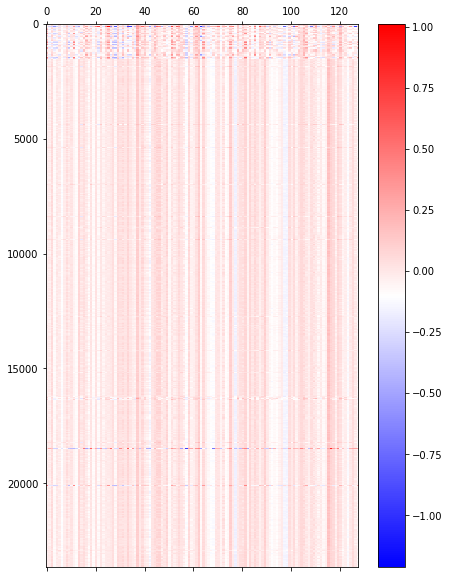

In [25]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect='auto', figsize=(7,10))

Euclidean with adaptive threshold
Euclidean dist


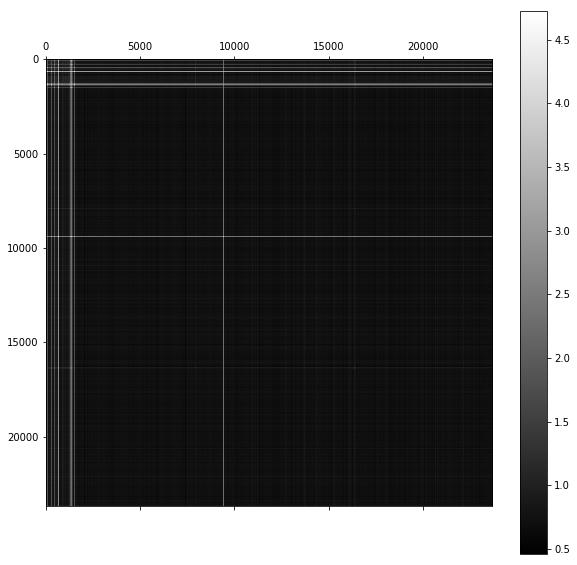

In [26]:
delattr(siamese, "reconstructed_adj") if hasattr(siamese, "reconstructed_adj") else None
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", 
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(),
                                            ), figsize=(10, 10))

Euclidean dist


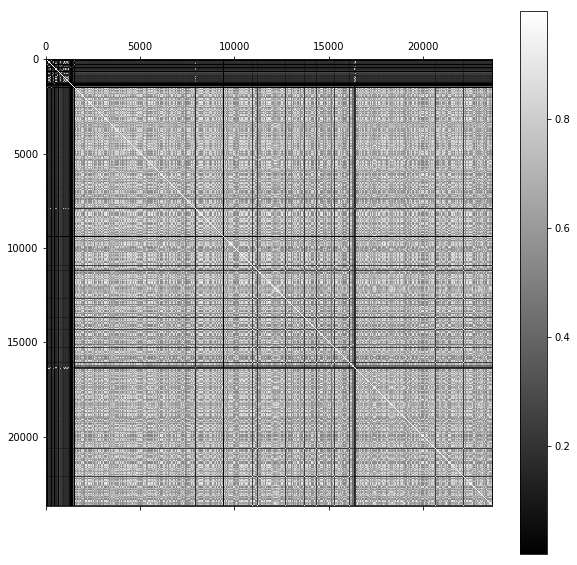

In [27]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", 
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(), 
                                             ), figsize=(10,10))

# Save Model & Embedding

In [ ]:
# siamese.save_model("lstm_model.e30.h5", model="lstm", logdir=True)

In [ ]:
# siamese.truncating = "post"
# siamese.save_embeddings("lmn_train.triplet.shortest.biogrid.full.euclidean.trunc.emb", 
#                         variable_length=False, recompute=False, minlen=100)

# Import different models

In [15]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding
from moge.embedding.sequence_based_embedding import BioVecEmbedding, iDeepVEmbedding, LncTarInteraction

# biovec_emb = BioVecEmbedding(network, {"MIR": "moge/data/biovec/miRNA_protvec.model",
#                          "GE": "moge/data/biovec/mRNA_protvec.model",
#                          "LNC": "moge/data/biovec/lncRNA_protvec.model"})

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=network.node_list)


biovec_emb = ImportedGraphEmbedding(d=100, method_name="BioVec")
biovec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.biovec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)


print()

node2vec imported (22250, 128)
BioVec imported (23653, 100)
LINE imported (22250, 128)
HOPE imported (22250, 128)
SDNE imported (22250, 128)
rna2rna imported (23653, 128)



In [16]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["BioVec"] = biovec_emb
# methods["rna2rna"] = rna2rna_emb
methods["rna2rna"] = siamese

# Prepare Validation Set

In [28]:
from moge.network.edge_generator import DataGenerator

negative_sampling_ratio = 1.0
generator_val = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1,
                             training_adj=network.get_adjacency_matrix(edge_types=["d"], 
                                                                       node_list=network_val.node_list))
generator_val.on_epoch_end()

Ed_count: 244608 , Eu_count: 0 , En_count: 0
Ens_count: 244608
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}


lncrna2target
Ed_count: 564 , Eu_count: 0 , En_count: 0 , Ens_count 564


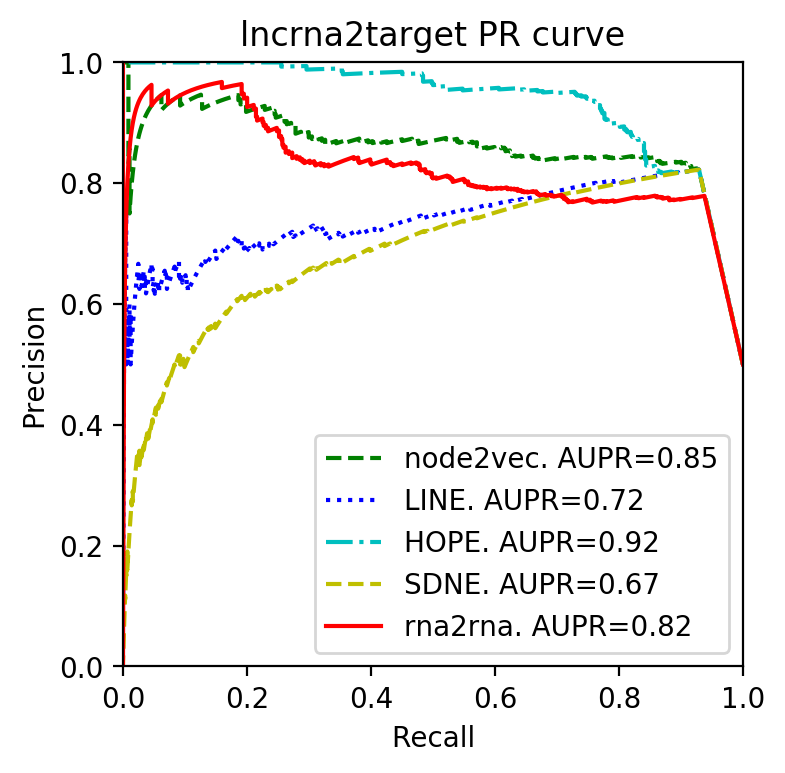

lncBase
Ed_count: 156149 , Eu_count: 0 , En_count: 0 , Ens_count 156149


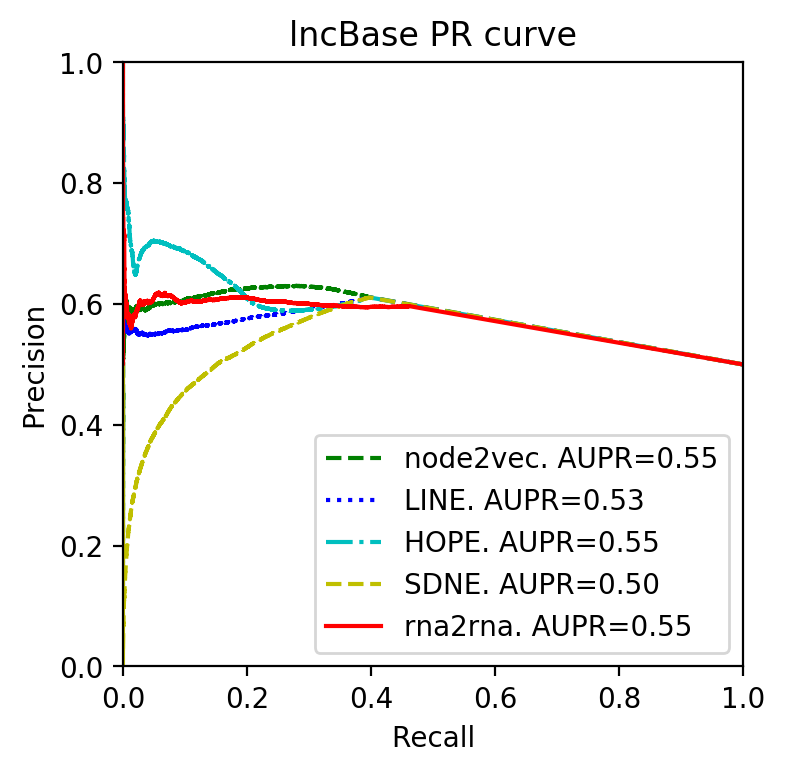

miRTarBase
Ed_count: 55891 , Eu_count: 0 , En_count: 0 , Ens_count 55891


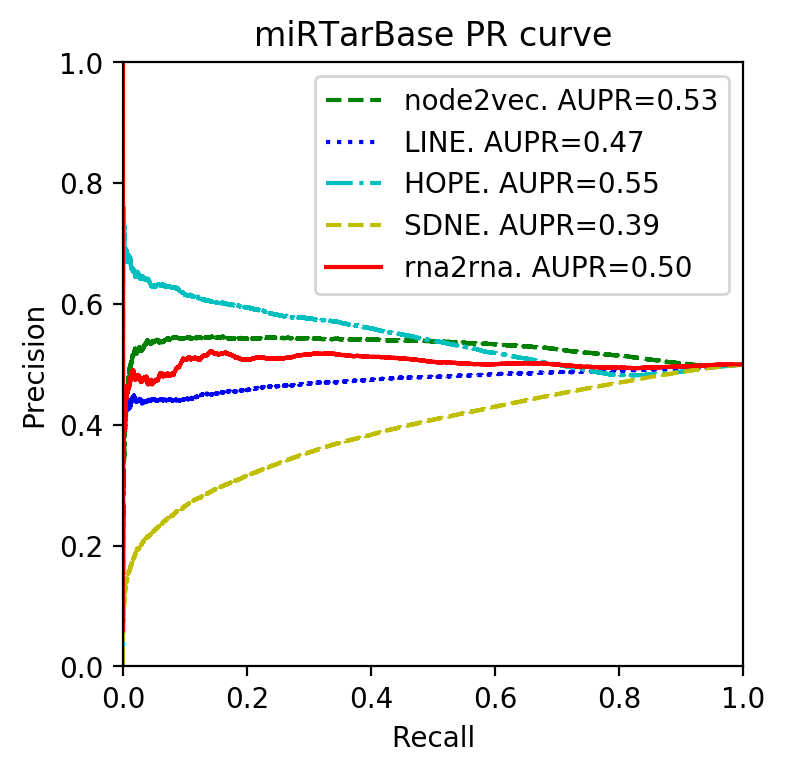

BioGRID
Ed_count: 31633 , Eu_count: 0 , En_count: 0 , Ens_count 31633


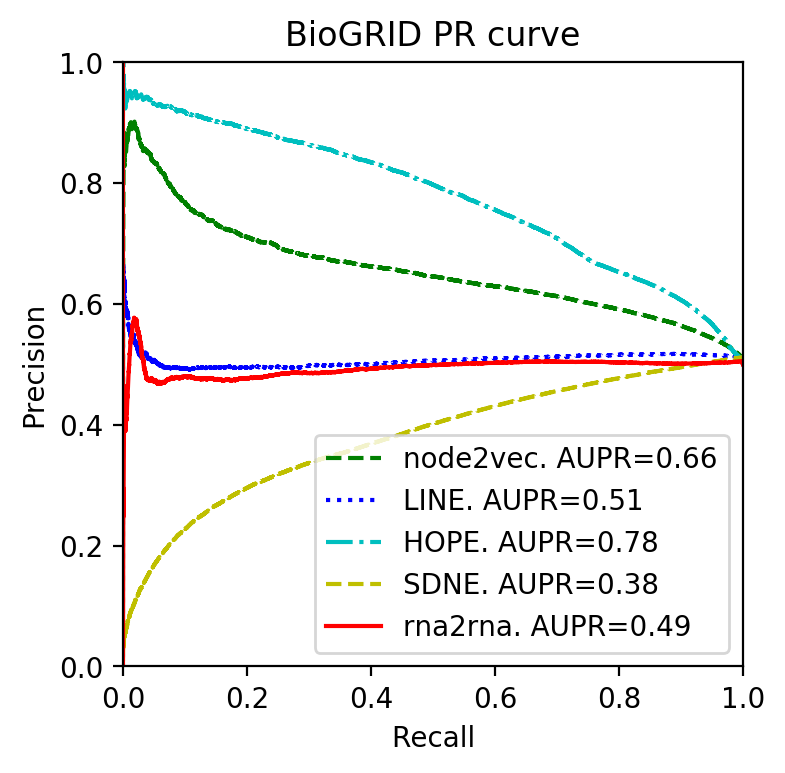

In [29]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_val, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target"),
                                            ("MIR", "LNC", "lncBase"),
                                            ("MIR", "GE", "miRTarBase"), 
                                            ("GE", "GE", "BioGRID"), 
#                                             ("LNC", "GE", "lncRInter"),
#                                             ("LNC", "GE", "LncReg"),
                                              ])

# Prepare Training set (for graph reconstruction)

In [30]:
from moge.network.edge_generator import DataGenerator

negative_sampling_ratio = 1.0
generator_train = DataGenerator(network=network, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=1,
                             maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1)
generator_train.Eu_count = 0
generator_train.En_count = 0
generator_train.on_epoch_end()

Ed_count: 583033 , Eu_count: 454092 , En_count: 386463
Ens_count: 583033
word index: {'A': 1, 'G': 2, 'C': 3, 'T': 4}


lncrna2target
Ed_count: 18044 , Eu_count: 0 , En_count: 0 , Ens_count 18044


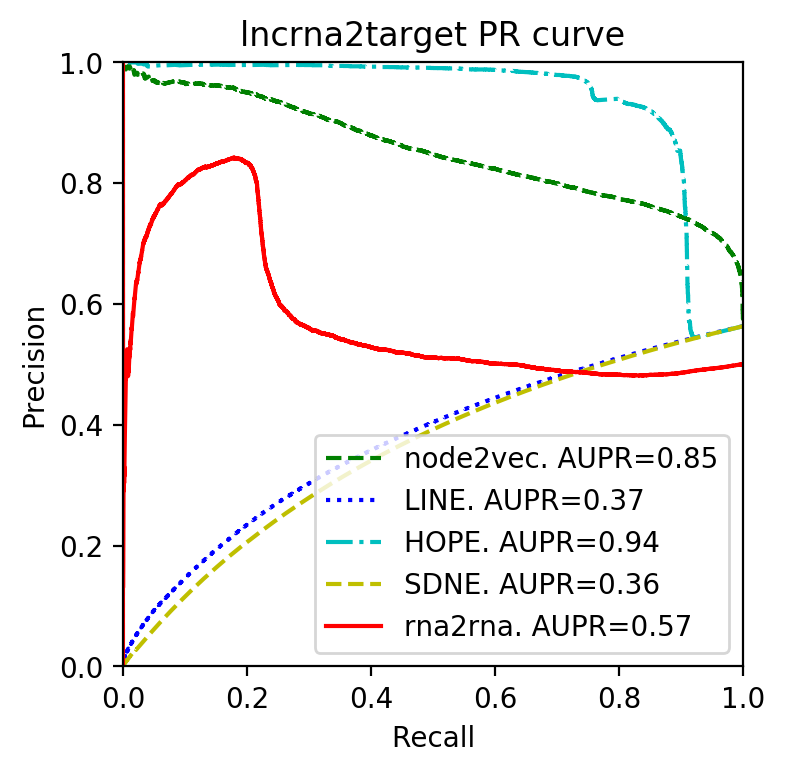

lncBase
Ed_count: 16168 , Eu_count: 0 , En_count: 0 , Ens_count 16168


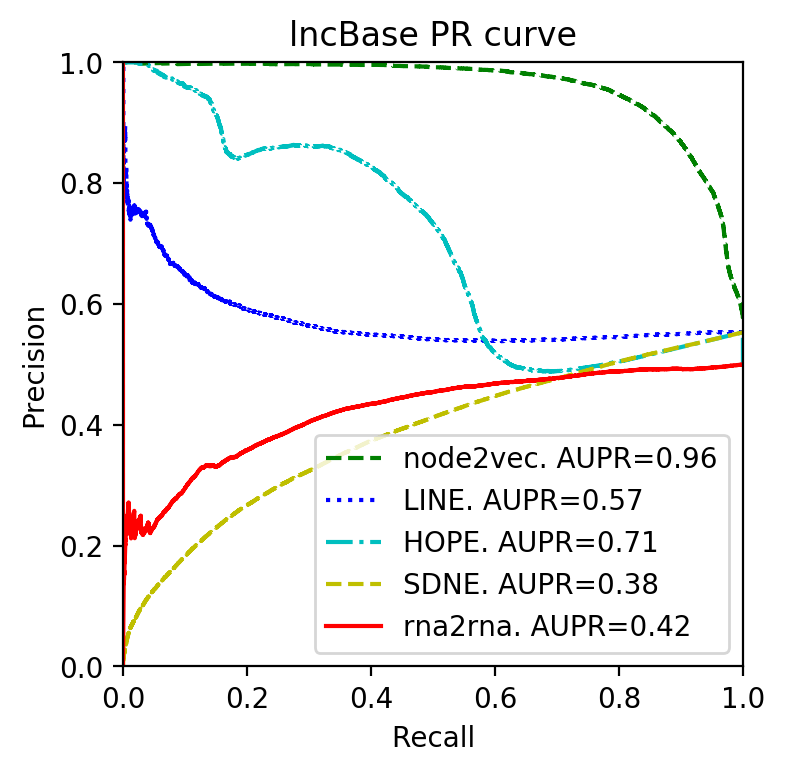

miRTarBase
Ed_count: 265472 , Eu_count: 0 , En_count: 0 , Ens_count 265472


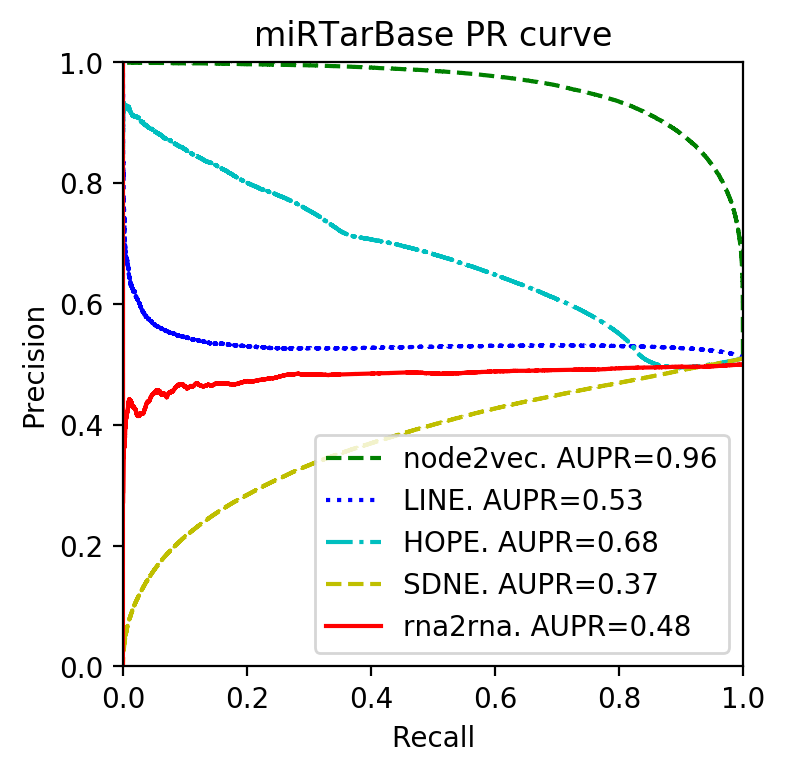

BioGRID
Ed_count: 283349 , Eu_count: 0 , En_count: 0 , Ens_count 283349


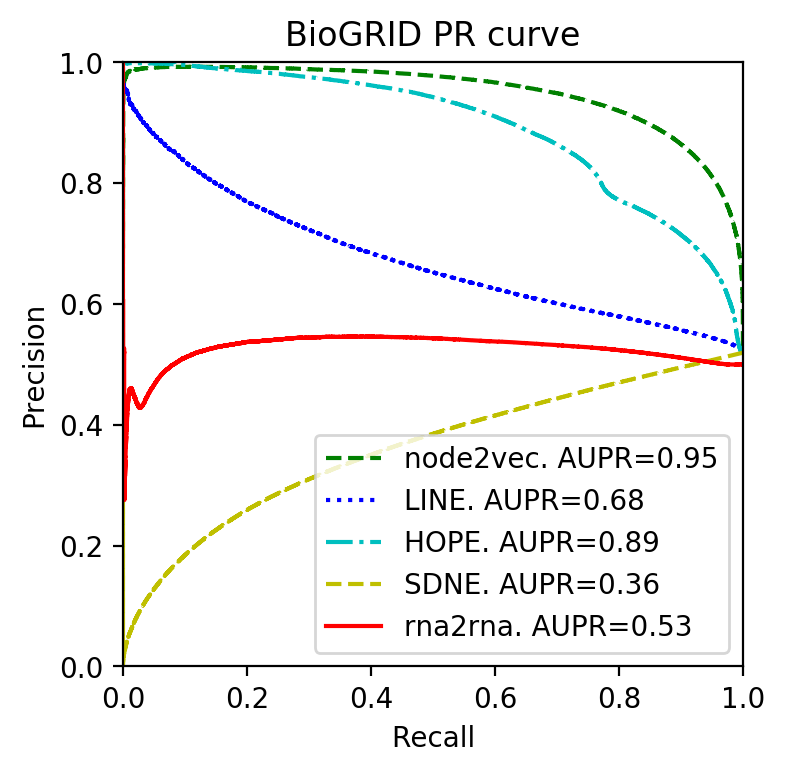

In [31]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_train, 
                                        tests=[("LNC", "GE", "lncrna2target"),
                                               ("MIR", "LNC", "lncBase"),
                                               ("MIR", "GE", "miRTarBase"), 
                                               ("GE", "GE", "BioGRID"), 
                                              ])

# Experimental Results

In [32]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

database_tests = [
    ("LNC", "GE", "lncrna2target"),
    ("MIR", "LNC", "lncBase"),
    ("MIR", "GE", "miRTarBase"), 
    ("GE", "GE", "BioGRID"), 
    ("LNC", "GE", "lncRInter"),
    ("LNC", "GE", "LncReg"),
]
top_k = 10000

for source, target, database in database_tests:
    print(database)
    results = {}
    for method in methods.keys():
        results[method] = \
              evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                                       node_list=network.nodes[source], node_list_B=network.nodes[target], 
                                       edge_type="d", databases=[database], top_k=top_k)
        
    bar_chart(results, measures=['Precision', 'Recall'], 
              title="Top-k (k={}) Predictions on {}".format(top_k, database))

lncrna2target


TypeError: get_edgelist() got an unexpected keyword argument 'edge_types'

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="locus_type", 
                                          max_clusters=500, n_clusters=None)

bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'],
         title="Clustering Evaluation to {}".format("RNA Type"))

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="Family", 
                                          max_clusters=500, n_clusters=None)
    
bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'], 
          title="Clustering Evaluation to {}".format("RNA Family"))

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Family", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Disease association", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.utils import get_scalefree_fit_score

results = {}
modalities = [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]
labels = ["miRNA-lncRNA", "lncRNA-miRNA", "lncRNA-mRNA", "miRNA-mRNA", "mRNA-mRNA"]
databases = ["lncBase", "lncBase", "lncrna2target", "miRTarBase", "BioGRID"]

for method in ["Databases"]+list(methods.keys()):
    if method == "BioVec":
        continue
    elif method == "Databases":
        sub_result = {}
        for (A, B), label, database in zip(modalities, labels, databases):
            adj = network.get_adjacency_matrix(edge_types=["d"], 
                                               node_list=network.node_list,
                                               databases=[database,])
            network_degrees = np.sum(adj, axis=1)
            sub_result[label] = get_scalefree_fit_score(network_degrees, plot=False)
        results[method] = sub_result
    else:
        sub_result = {}
        for (A, B), label in zip(modalities, labels):
           sub_result[label] = methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B])
        results[method] = sub_result
    
bar_chart(results, measures=labels, title="Scale-free fit scores")

# Visualization

In [50]:
siamese.node_list.index("FAM127B")

ValueError: 'FAM127B' is not in list

In [49]:
siamese.generator_train.genes_info["FAM127B"]

KeyError: 'FAM127B'

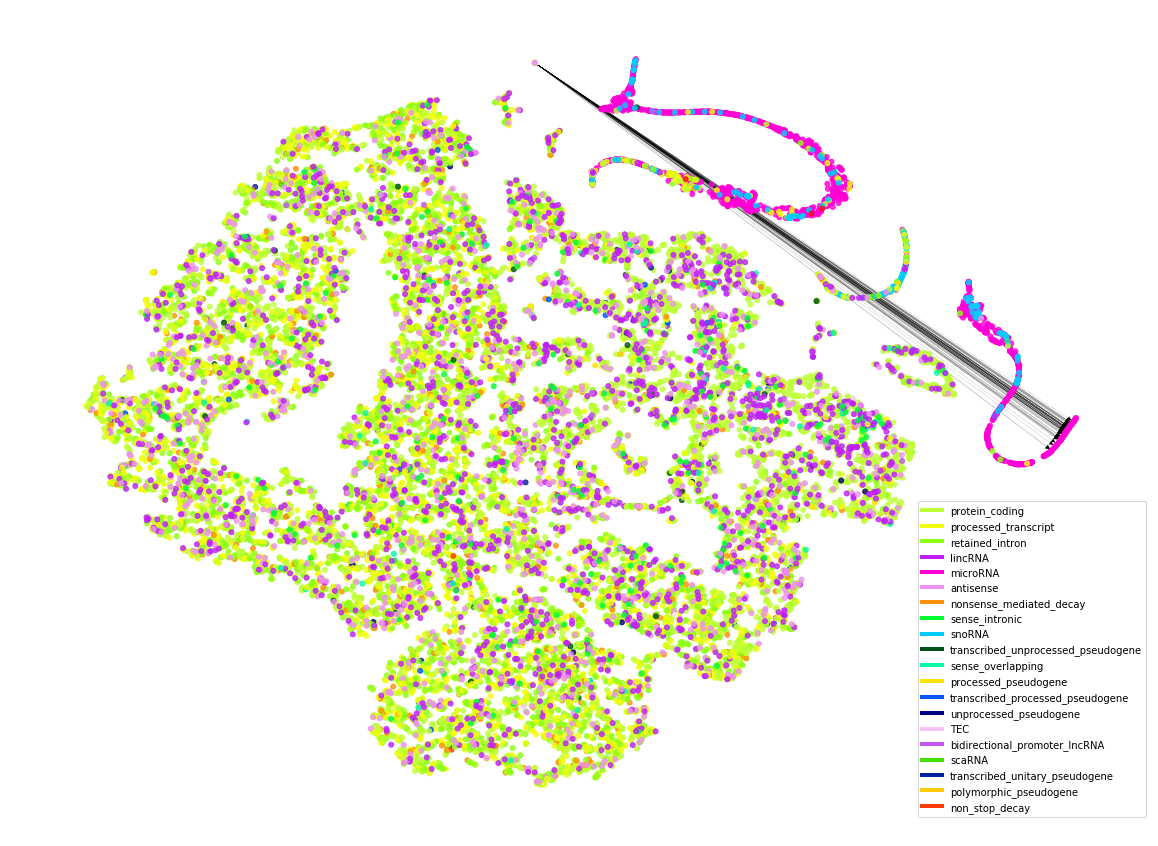

<Figure size 432x288 with 0 Axes>

In [54]:
from moge.visualization.visualize_embedding import visualize_embedding
# siamese.process_embeddings(variable_length=False)
# delattr(siamese, "node_pos")
# nodes_to_visualize = list(set(siamese.generator_train.get_nonzero_nodelist()) | set(siamese.generator_val.get_nonzero_nodelist()))
# nodes_test = list(set(siamese.generator_val.get_nonzero_nodelist()) - set(siamese.generator_train.get_nonzero_nodelist()))
# print(len(nodes_test))
visualize_embedding(siamese, network=network, node_label="locus_type", top_k=0,
#                     edgelist=network_val.get_edgelist(node_list=nodes_to_visualize, 
#                                                       edge_types=["d"])[:500],
#                     test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="gist_ncar",
                    file_name="moge/data/Results/siamese_online_triplet_euclidean",
                   )

In [ ]:
siamese.process_embeddings(variable_length=True, minlen=200)
delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, node_label="locus_type", 
#                     edgelist=network_val.get_edgelist(node_list=nodes_to_visualize, 
#                                                       edge_types=["d"])[:500],
#                     test_nodes=nodes_test,
                    cmap="gist_ncar",)

# AUC Rate

%%javascript
Jupyter.notebook.session.delete();